<a href="https://colab.research.google.com/github/jc39963/Interpretable_ML/blob/main/Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #1
### Interpretable ML
### Jenny Chen




[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jc39963/Interpretable_ML/blob/main/code/Interpretable_ML.ipynb)

👉 Make sure to delete the helper markdown below in your own notebook!

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [3]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Interpretable_ML" # Change to your repo name
git_path = 'https://github.com/jc39963/Interpretable_ML.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
#notebook_dir = 'code'
path_to_notebook = os.path.join(repo_name)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'Interpretable_ML' already exists and is not an empty directory.
/content/Interpretable_ML
README.md


#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [122]:
import kagglehub
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.stattools as stattools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, auc, ConfusionMatrixDisplay, roc_curve


In [ ]:
from google.colab import userdata
userdata.get('secretName')

In [3]:

# Download dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [4]:
data = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## $1.$  Exploratory Analysis and Assumptions

### a. Recoding Variables

In [6]:
#recoding as binary
data["Churn"] = [1 if x == "Yes" else 0 for x in data['Churn']]

In [7]:
#turning other variables categorical
data["PaymentMethod"] = data["PaymentMethod"].astype('category')
data["Contract"] = data["Contract"].astype('category')
data["InternetService"] = data["InternetService"].astype('category')
data["OnlineBackup"] = data["OnlineBackup"].astype('category')
data["gender"] = data["gender"].astype('category')
data["MultipleLines"] = data["MultipleLines"].astype('category')

In [8]:
#recoding other features as binary
data["Partner"] = [1 if x == "Yes" else 0 for x in data['Partner']]
data["Dependents"] = [1 if x == "Yes" else 0 for x in data['Dependents']]
data["PhoneService"] = [1 if x == "Yes" else 0 for x in data['PhoneService']]
data["PaperlessBilling"] = [1 if x == "Yes" else 0 for x in data['PaperlessBilling']]
data["OnlineSecurity"] = [1 if x == "Yes" else 0 for x in data['OnlineSecurity']]
data["DeviceProtection"] = [1 if x == "Yes" else 0 for x in data['DeviceProtection']]
data["TechSupport"] = [1 if x == "Yes" else 0 for x in data['TechSupport']]
data["StreamingTV"] = [1 if x == "Yes" else 0 for x in data['StreamingTV']]
data["StreamingMovies"] = [1 if x == "Yes" else 0 for x in data['StreamingMovies']]

In [9]:
#finding null values to recode this variable to a float
data["TotalCharges"] = data["TotalCharges"].replace(' ', pd.NA)


In [10]:
data.TotalCharges.isna().sum() #only 11 missing
data.dropna(inplace=True) #drop missing

In [11]:
#recode to numeric
data["TotalCharges"] = data["TotalCharges"].astype('float')

In [12]:
data.dtypes #checking dtypes

,0
customerID,object
gender,category
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,category
InternetService,category
OnlineSecurity,int64


### b. Checking Assumptions  
- Run models and plot residuals to check assumptions

### i. Linear Regression  

***Assumptions***:
*   **Linearity** ❌
*   **Independence of observations** ✅ - according to the data card from Kaggle, the data is all from different customers suggesting independence of observations
*   **Homoscedasticity of residuals** ❌
*   **Normality of residuals** ❌
* **No autocorrelation between residuals**✅
* **No multicollinearity** ✅
* **No endogeneity** (no correlation between a predictor and error term) ✅ - Broken when outcome (Y) also causes X, there is measurement errors in predictors, and important confounders / variables are omitted. Therefore, it seems reliant on the data collection and data used. Since the data is a sample dataset from IBM on Kaggle, I included all variables as predictors, and it does not make much sense for churn to cause any of the predictor variables used, it seems this assumption can be passed.
* **Correct specification** - This is dependent on your needs and data and understanding of the specific question / context of your data and ask and also the checking of other assumptions in this list (e.g. multicollinearity for deciding which variables to exclude)  




- *Note:* Understanding endogeneity and the explanation was done with assistance from ChatGPT (free version) and code generation for residuals histogram, QQ plot, and VIF were also done with assistance from ChatGPT. The prompt was to explain endogeneity and that the assumption is or is not met with linear regression. For my code prompts, I asked how to calculate VIF and plot residuals after having used a statsmodel.api formula linear regression model.





In [13]:
# Get all column names except customerID and Churn
predictor_cols = [col for col in data.columns if col not in ['customerID', 'Churn']]

# Create formula as string
formula = 'Churn ~ ' + ' + '.join(predictor_cols)

# Define model
lin_model = smf.ols(formula=formula, data=data).fit()



 **Plotting Residuals vs. Predicted**  

* The residuals vs. predicted plot show that the assumption of **linearity** is violated. The residuals are in 2 distinct lines instead of a random cloud / spread as they should look if the assumption of linearity was met.  Additionally, the plot shows the assumption of **homoscedasticity** is not met as we do not see a random spread of the residuals around 0, but rather 2 distinct straight lines. These are likely due to the fact that the outcome is binary rather than continuous, therefore.  



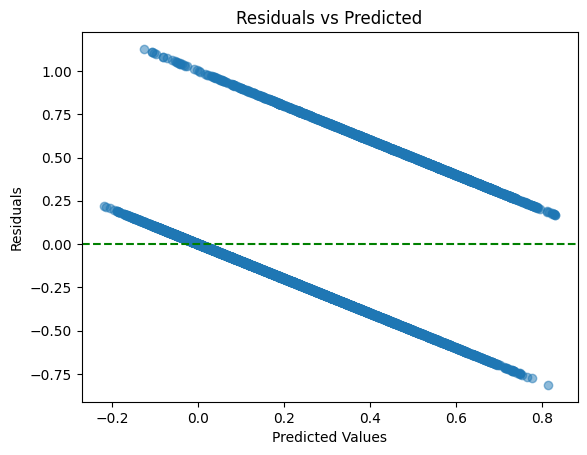

In [15]:
fitted = lin_model.fittedvalues
residuals = lin_model.resid

# residuals vs predicted plot
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="green", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


**Plotting distribution of residuals and QQ plot**

* The histogram of residuals shows that the **assumption of normality** of residuals is violated as the residuals are not normally distributed, instead, we see 2 peaks within the plot (likely because the outcome is binary so there is a peak around the outcome of 1 and one at 0). This is further corroborated by the QQ plot in which the points do not adhere well to the straight line, therefore the theoretical quantiles and actual quantiles from the residuals do not align, suggesting they are not normally distributed.


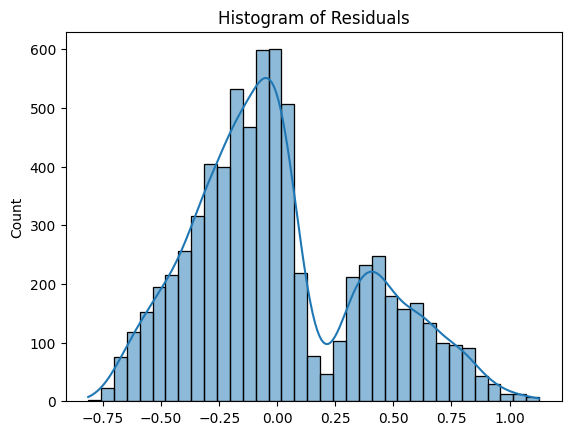

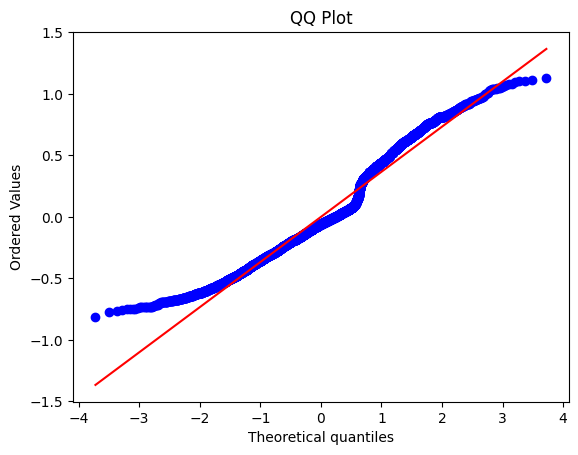

In [19]:

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot - code from ChatGPT
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

**VIF for multicollinearity**

* The assumption of multicollinearity is violated currently with the variables I have included as predictors as we see VIFs of very high numbers (much greater than 10) and up to infinity. This is likely because things like having no internet service shows up in other variables like 'OnlineBackup' where having no internet service is a category and MonthlyCharges is also likely highly correlated with whether they have certain services or not.

In [40]:
# Code from ChatGPT
# Get variables and names
X = lin_model.model.exog
names = lin_model.model.exog_names

# Compute VIF
vif_data = pd.DataFrame({
    "Variable": names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

vif_data

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Intercept,0.000000
1,gender[T.Male],1.002106
2,MultipleLines[T.No phone service],inf
3,MultipleLines[T.Yes],7.289761
4,InternetService[T.Fiber optic],148.500814
5,InternetService[T.No],inf
6,OnlineBackup[T.No internet service],inf
7,OnlineBackup[T.Yes],6.796678
8,Contract[T.One year],1.625784
9,Contract[T.Two year],2.652328


**Durbin-Watson to check autocorrelation**
* The Durbin-Watson Statistic is 2.004 suggesting that the **assumption of autocorrelation passes and there is essentially no autocorrelation between residuals**.  

In [43]:
  # Code from online after asking how to do Durbin-Watson in Python
  dw_statistic = stattools.durbin_watson(residuals)
  print("Durbin-Watson Statistic:", dw_statistic)

Durbin-Watson Statistic: 2.0043473189317376


### ii. Logistic Regression

***Assumptions***:
* **Linearity** ❌
* **No multicollinearity** ❌ - Same as in Linear regression in Part i. above, the VIFs will be the same and did not pass
* **Independence of observations** ✅ - Observations are independent by design of the data collection
* **No influential outliers** ✅
* **Absence of perfect separation** ✅
* **Large sample size** ✅

In [46]:
#logistic model
log_model = smf.logit(formula=formula, data=data).fit()


Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8


**Box-Tidwell Test**

*Note:* Referenced ChatGPT for ways to test linearity for logistic regression and was explained what a Box-Tidwell Test was. I then implemented the transformations and new model on my own.  

* Using the Box-Tidwell test to add an interaction term for each continuous predictor (tenure, MonthlyCharges, and TotalCharges) where the predictor is multiplied by it's natural log, I then ran a new logit model and evaluated the associated coefficients and p-values for those 3 interaction terms. The p-value for 'tenure' transformed variable is $1.5e-9$ which is statistically significant $<0.05$ suggesting that the assumption of linearity for tenure is violated. The p-value for 'MonthlyCharges' is 0.036 and for 'TotalCharges' is 0.024 which also fall under the threshold for statistical significance so the **assumption of linearity does not hold**.

In [78]:
# creating box-tidwell interaction terms for the 2 continuous predictors
data["cont_1"] = data["tenure"] * np.log(data["tenure"])
data["cont_2"] = data["MonthlyCharges"] * np.log(data["MonthlyCharges"])
data["cont_3"] = data["TotalCharges"] * np.log(data["TotalCharges"])
box_tid_formula = formula + " + cont_1 + cont_2 + cont_3"

In [79]:
# run new model with the interaction terms
bt_logit = smf.logit(formula=box_tid_formula, data=data).fit()
bt_logit.summary()

Optimization terminated successfully.
         Current function value: 0.408493
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7005
Method:                           MLE   Df Model:                           26
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.2945
Time:                        17:46:33   Log-Likelihood:                -2872.5
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    2.1969   2.15e+06   1.02e-06      1.000   -4.21e+06    4.21e+06
gender[T.Male]                              -0.0239      0.066     -0.364      0.716      -0.152       0.105
MultipleLines[T.No phone service]            0.9328   2.15e+06   4.34e-07      1.000   -4.21e+06    4.21e+06
MultipleLines[T.Yes]                         0.5140      0.179      2.867      0.004       0.163       0.865
InternetService[T.Fiber optic]               1.7730      0.804      2.205      0.027       0.197       3.349
InternetService[T.No]                       -1.1041   9.07e+06  -1.22e-07      1.000   -1.78e+07    1.78e+07
OnlineBackup[T.No internet service]         -1.1041   9.07e+06  -1.22e-07      1.000   -1.78e+07    1.78e+07
OnlineBackup[T.Yes]                          0.0312      0.177      0.176      0.860      -0.315       0.378
Contract[T.One year]                        -0.6760      0.110     -6.137      0.000      -0.892      -0.460
Contract[T.Two year]                        -1.6722      0.188     -8.872      0.000      -2.042      -1.303
PaymentMethod[T.Credit card (automatic)]    -0.0781      0.114     -0.685      0.493      -0.302       0.145
PaymentMethod[T.Electronic check]            0.2735      0.095      2.876      0.004       0.087       0.460
PaymentMethod[T.Mailed check]               -0.1114      0.117     -0.951      0.342      -0.341       0.118
SeniorCitizen                                0.2233      0.085      2.626      0.009       0.057       0.390
Partner                                      0.0219      0.079      0.278      0.781      -0.133       0.176
Dependents                                  -0.1227      0.091     -1.356      0.175      -0.300       0.055
tenure                                      -0.3065      0.049     -6.286      0.000      -0.402      -0.211
PhoneService                                 1.2641   2.15e+06   5.89e-07      1.000   -4.21e+06    4.21e+06
OnlineSecurity                              -0.1602      0.180     -0.888      0.374      -0.514       0.193
DeviceProtection                             0.1847      0.178      1.040      0.299      -0.164       0.533
TechSupport                                 -0.1228      0.182     -0.674      0.500      -0.480       0.234
StreamingTV                                  0.6233      0.329      1.895      0.058      -0.021       1.268
StreamingMovies                              0.6281      0.329      1.909      0.056      -0.017       1.273
PaperlessBilling                             0.3542      0.076      4.676      0.000       0.206       0.503
MonthlyCharges                              -0.1791      0.076     -2.366      0.018      -0.327      -0.031
TotalCharges                                 0.0025      0.001      2.203      0.028       0.000       0.005
cont_1                                       0.0613      0.010      6.041      0

**Cook's Distance for Influential Points**
* There seems to be maybe 2 points that appear much higher than the others in their Cook's Distance suggesting they may be Influential Outliers, though their values of 0.12 are still vastly below 0.5 or 1 which seem to be thresholds for influential points according to my Google searches and ChatGPT ("Rule of thumb: > 1 is problematic, but even 0.5 could be influential"). The model could be run without those 2 points, but their low Cook's Distance suggest that **the assumption is not necessarily violated**

/usr/local/lib/python3.12/dist-packages/statsmodels/base/_prediction_inference.py:615: RuntimeWarning: invalid value encountered in sqrt
  linpred_se=np.sqrt(linpred_var),
/usr/local/lib/python3.12/dist-packages/statsmodels/base/_prediction_inference.py:41: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var_pred)


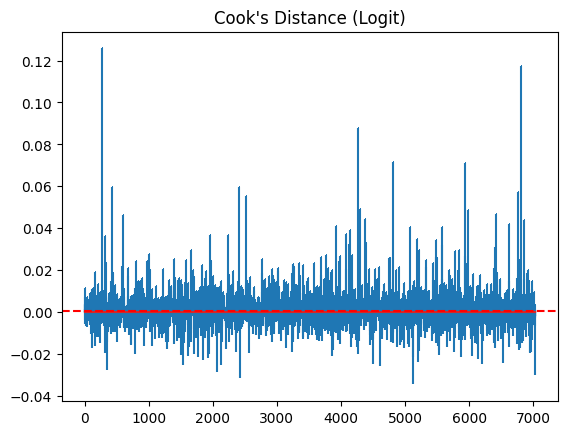

In [66]:
influence = log_model.get_influence()
summary_frame = influence.summary_frame()

# Cook's Distance
summary_frame["cooks_d"] = influence.cooks_distance[0]
plt.stem(summary_frame["cooks_d"], markerfmt=",")
plt.title("Cook's Distance (Logit)")
plt.show()



**Perfect Separation Check**  
* Looking at the coefficients for each predictor, none of the values are extreme and are all $<|2|$. I looked online for how to check for this assumption, and the most common answer was to examine the coefficient estimates as infinite or extremely large estimates would indicate perfect separation. Since none of the coefficients for this model are large, the **assumption of no perfect separation holds**.

In [53]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Sun, 14 Sep 2025   Pseudo R-squ.:                  0.2845
Time:                        16:25:35   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.8340      0.448      1.861      0.063      -0.045       1.713
gender[T.Male]                              -0.0218      0.065     -0.337      0.736      -0.149       0.105
MultipleLines[T.No phone service]            0.3313        nan        nan        nan         nan         nan
MultipleLines[T.Yes]                         0.4484      0.177      2.530      0.011       0.101       0.796
InternetService[T.Fiber optic]               1.7475      0.798      2.190      0.029       0.183       3.312
InternetService[T.No]                       -0.8931    2.2e+07  -4.06e-08      1.000   -4.31e+07    4.31e+07
OnlineBackup[T.No internet service]         -0.8931    2.2e+07  -4.06e-08      1.000   -4.31e+07    4.31e+07
OnlineBackup[T.Yes]                          0.0260      0.175      0.148      0.882      -0.318       0.370
Contract[T.One year]                        -0.6608      0.108     -6.142      0.000      -0.872      -0.450
Contract[T.Two year]                        -1.3571      0.176     -7.691      0.000      -1.703      -1.011
PaymentMethod[T.Credit card (automatic)]    -0.0878      0.114     -0.770      0.442      -0.311       0.136
PaymentMethod[T.Electronic check]            0.3045      0.094      3.222      0.001       0.119       0.490
PaymentMethod[T.Mailed check]               -0.0576      0.115     -0.501      0.616      -0.283       0.168
SeniorCitizen                                0.2168      0.085      2.564      0.010       0.051       0.382
Partner                                     -0.0004      0.078     -0.005      0.996      -0.153       0.152
Dependents                                  -0.1485      0.090     -1.655      0.098      -0.324       0.027
tenure                                      -0.0606      0.006     -9.716      0.000      -0.073      -0.048
PhoneService                                 0.5027      0.590      0.852      0.394      -0.654       1.660
OnlineSecurity                              -0.2054      0.179     -1.150      0.250      -0.556       0.145
DeviceProtection                             0.1474      0.176      0.836      0.403      -0.198       0.493
TechSupport                                 -0.1805      0.181     -0.999      0.318      -0.534       0.173
StreamingTV                                  0.5905      0.326      1.810      0.070      -0.049       1.230
StreamingMovies                              0.5993      0.327      1.834      0.067      -0.041       1.240
PaperlessBilling                             0.3424      0.074      4.596      0.000       0.196       0.488
MonthlyCharges                              -0.0403      0.032     -1.270      0.204      -0.103       0.022
TotalCharges                                 0.0003   7.06e-05      4.657      0.000       0.000       0.000
================================================================================

In [71]:
len(predictor_cols)

19

**Sample Size**  
* The rule of thumb from online searching seems to be at least 10 observations of the least common outcome (in this case Churn = 1) for each predictor of the model (we have 19 predictors). A formula given was $N = \frac{10*k}{p}$ where $N$ = number of observations, $k$ = number of independent variables, and $p$ = proportion of least frequent outcome. Therefore we must have at least $\frac{10 * 19}{0.362} = 525$ observations in our dataset. We have 7302 observations in our data set so this **assumption passes.**

In [77]:
#calculating proportion of least frequent outcome
print(data["Churn"].value_counts())
proportion_churn = 1869 / 5163
proportion_churn


Churn
0    5163
1    1869
Name: count, dtype: int64


0.36199883788495063

In [76]:
print(f"The sample size must be at least {10*19 / proportion_churn:.0f}")

The sample size must be at least 525


### iii. Generalized Additive Models (GAM)

ASsumes the outcome can be modeled by a sum of arbitrary fxns of each feature

## 2. Linear Regression  
* Based on the assumptions from Part 1. I will take out TotalCharges as the VIF was very high for MonthlyCharges (866) and that is likely because they are colinear, but keeping MonthlyCharges and tenure together gives information on the length of a customer's retention and charge amount which may be more informative than keeping TotalCharges and tenure (might be redundant as high TotalCharge could indicate high tenure). I will also take out 'PhoneService' since that overlaps with 'MultipleLines' where there is a 'NoPhoneService' category and remove the 'NoPhoneService' category as well. I will also do that for 'InternetService' and 'OnlineBackup' where there is a 'NoInternetService' category. I will remove "StreamingTV" as that overlaps with "StreamingMovies".
* I did not do lasso or ridge regression since I removed features based on the VIF and multicollinearity.

In [107]:
# create variables
y = data["Churn"].copy()
X = data.drop(columns=["Churn", "customerID", "TotalCharges", "PhoneService", "StreamingTV", "cont_1", "cont_2", "cont_3"])

In [108]:
X = pd.get_dummies(X, drop_first=True)
#dropping the redundant / highly colinear columns
X = X.drop(["InternetService_No", "OnlineBackup_No internet service", "MultipleLines_No phone service"], axis=1)

In [109]:
#from interpretable-ml notebook in Duke-XAI repo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    return model, y_pred

#fit model
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")



Linear Regression:
MSE: 0.15
R2 Score: 0.24
SeniorCitizen: 0.0226
Partner: 0.0025
Dependents: -0.0128
tenure: -0.1139
OnlineSecurity: -0.0311
DeviceProtection: -0.0046
TechSupport: -0.0324
StreamingMovies: 0.0143
PaperlessBilling: 0.0214
MonthlyCharges: 0.0772
gender_Male: -0.0018
MultipleLines_Yes: 0.0043
InternetService_Fiber optic: 0.0336
OnlineBackup_Yes: -0.0143
Contract_One year: -0.0546
Contract_Two year: -0.0390
PaymentMethod_Credit card (automatic): -0.0041
PaymentMethod_Electronic check: 0.0349
PaymentMethod_Mailed check: -0.0106


In [110]:
data["MonthlyCharges"]

,MonthlyCharges
0,29.85
1,56.95
2,53.85
3,42.30
4,70.70
...,...
7038,84.80
7039,103.20
7040,29.60
7041,74.40


**Interpretation of Model Coefficients**
This model (linear regression) predicts the expected value of Churn (between 0 and 1), therefore, the coefficients represent the change in the predicted probability of churn for a 1 unit increase in the predictor or when compared to a baseline category (if categorical) while holding all other variables constant.   

**Binary / categorical variables:**
* **Senior Citizen**: There is a 2.26% increase in predicted probability of churn as a senior citizen compared to a non-senior citizen holding all other variables constant.
* **Partner**: 0.25% increase (almost no effect) in churn when having a partner holding all other variables constant. Essentially, having a partner has almost no effect on churn rates.
* **Dependents**: Having dependents shows a 1.28% decrease in predicted probability of churn holding all other variables constant.
* **Online Security**: Having online security decreases probability of churn by 3.11% holding all other variables constant.
* **DeviceProtection**: 0.46 % decrease in churn (almost no effect) when having device protection holding all other variables constant.
* **TechSupport**: When customers have / get tech support, there's a 3.24% decrease in probability of churn holding all other variables constant.
* **StreamingMovies**: Having Streaming Movies slightly increases churn (~1.43%) compared to not subscribing, holding all other variables constant.
* **PaperlessBilling**: Having paperless billing slightly increases churn (~2.14%) when holding all other variables constant.
* **Gender (Male)**: Men have a 0.18% lower probability for churn (almost no effect) compared to women holding all other variables constant. Essentially, gender does not seem to have much of an effect on churn rates.
* **Multiple Lines**: Having multiple phone lines seems to increase probability of churn by ~0.43% (almost no effect) when holding all other variables constant.
* **Internet Service**: Customers with fiber optic service have a 3.36% increase in probability of churn compared to customers with DSL internet service when holding all other variables constant.
* **Online Backup**: Having online backup seems to decrease probability of churn by 1.43% holding all other variables constant.
* **Contract one year**: Having a one year contract decreases probability of churn by 5.46% compared to having a month-to-month contract when holding all other variables constant.
* **Contract two year**: Having a two year contract decreases probability of churn by 3.90% compared to having a month-to-month contract when holding all other variables constant.
* **Payment Method Credit Card**: Paying with credit card decreases probability of churn by 0.41% (almost no effect) compared to using a Bank transfer while holding all other variables constant. Essentially, credit card payment has almost no effect on churn rates.
* **Payment Method Electronic Check**: Paying with an electronic check shows a 3.49% increase in probability of churn when compared to bank transfer when holding all other variables constant.
* **Payment Method Mailed Check**: Paying with a mailed check shows a 1.06% decrease in probability of churn when compared to bank transfer payment when holding all other variables constant.

**Continuous Variables**:
* **tenure**: Each additional month of tenure reduces predicted churn probability by 0.1139 or 11.39%.
* **MonthlyCharges**: An increase in $1 in monthly charges increases probability of churn by 0.0772 or 7.72%.

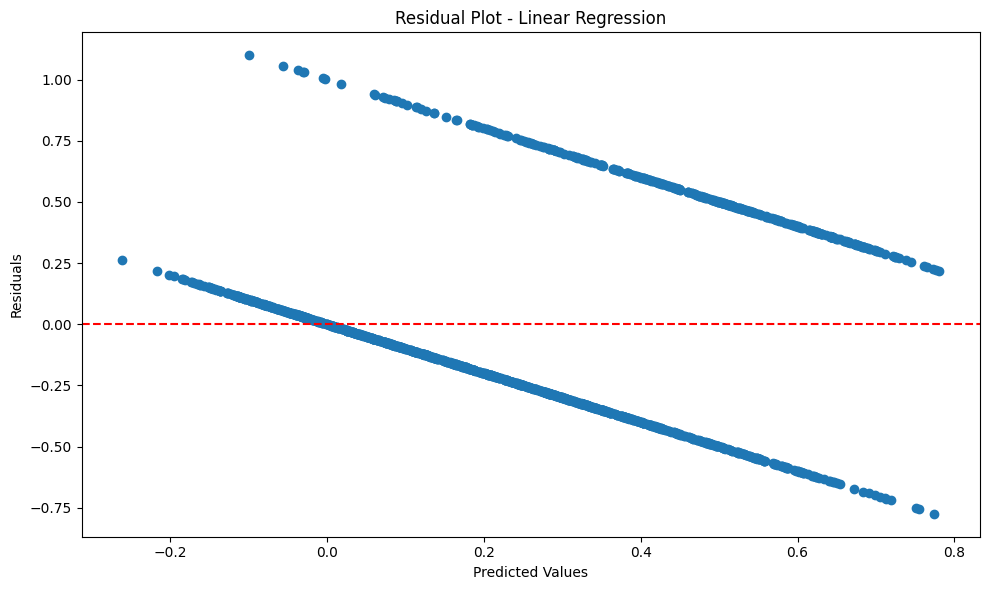

In [113]:


# Residual Plot from Duke-XAI hw notebook
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, lr_pred, 'Linear Regression')




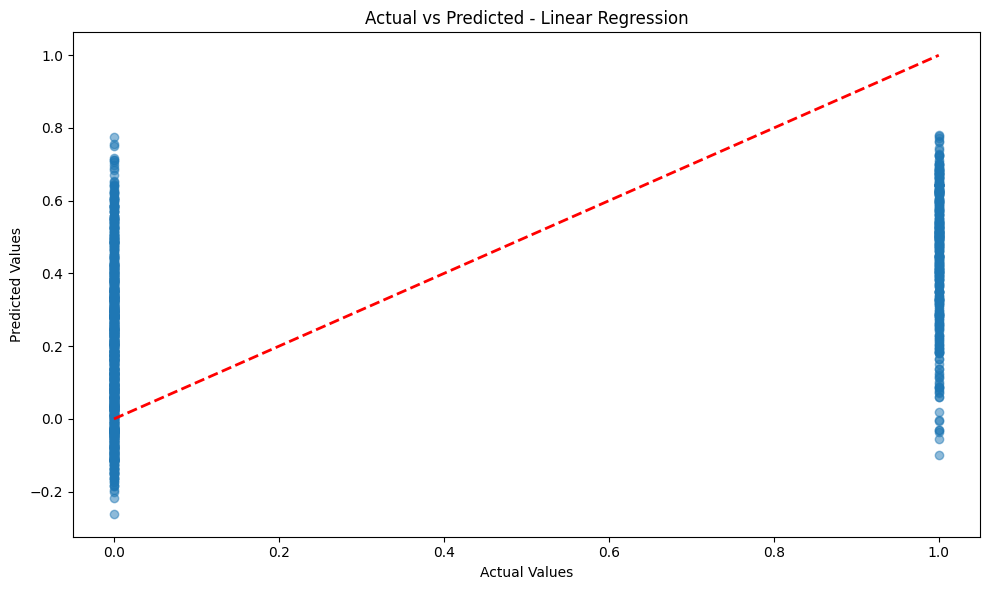

In [114]:


# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')




**Assessing Model Performance**:  
- My model has a MSE of 0.15 and an $R^2$ of 0.24.
- This means that only 24% of the variance was captured by my model and 76% of the variance is unexplained. Because the outcome variable we are predicting here is binary (0 to 1) but we modeled it with linear regression which is continuous, the outcome is on a probability from 0 to 1, so having a mean squared error of 0.15 means that on average, the squared difference between my predictions and actual values is 0.15. If you take the square root, that is a prediction that is off by 0.39 on average, which is quite large when the scale is from 0 to 1 as a probability. This suggests that the linear model is not ideal for modeling and predicting churn, a binary outcome variable, and this makes sense as we saw many of the assumptions needed for linear regression were not met in Part 1.  
- Additionally, the residuals vs. predicted plot, similar to in Part 1, show that the model is not adhering to assumptions needed for linear regression (no equal spread of residuals, there's a pattern in the residual plot) to really be robust and have predictions that are usable and informative.
- In the Actual vs. Predicted plot, the red line is perfect predictions and we see that because the actual values are only 0 or 1 (binary), it isn't really possible to model along the red line linearly, thus reducing our model's performance and accuracy.

### 3. Logistic Regression  
I will use the same predictors as the Linear Regression model as the same multicollinearity issues apply.

Accuracy: 0.7860696517412935
ROC AUC: 0.8252390369154791
Confusion Matrix:
 [[917 116]
 [185 189]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

                                  Feature  Coefficient  Odds_Ratio
0                           SeniorCitizen     0.111425    1.117870
1                                 Partner     0.024789    1.025098
2                              Dependents    -0.118392    0.888348
3                                  tenure    -0.825372    0.438072
4                          OnlineSecurity    -0.203103    0.816194
5                        DeviceProtection     0.014663    1.014771
6                             TechSupport    -0.185155    0.830975
7             

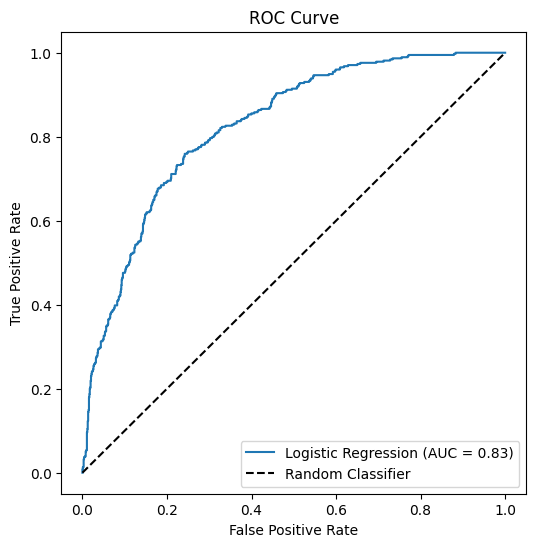

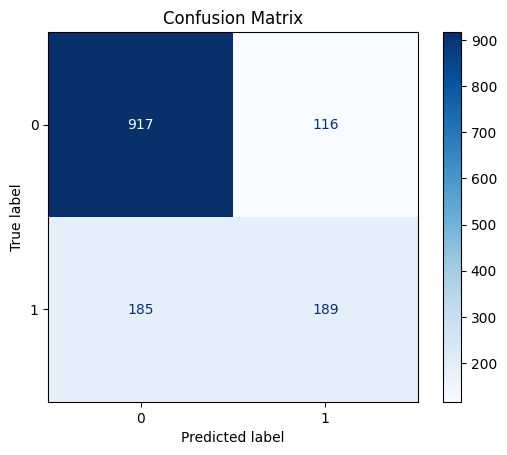

In [123]:
#adapted code from linreg to logistic with prompt to ChatGPT to help me create
#a function to evaluate logistic regression model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    coefs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0],
    "Odds_Ratio": np.exp(model.coef_[0])
})

    print(coefs)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = log_model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_estimator(
    log_model, X_test, y_test,
    cmap=plt.cm.Blues,
    values_format='d'
    )
    plt.title("Confusion Matrix")
    plt.show()

    return model, y_pred

#fit model
log_model, log_pred = evaluate_model(LogisticRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")


**Interpretation of Model Coefficients**:
For logistic regression, I put the coefficients as odd ratios by exponentiating them. This allows them to be interpreted as the multiplicative change in the odds per one unit change in the predictor or between a predictor and its reference category (if categorical)
* **SeniorCitizen**: The odds of churning increase by 11.79% (odds ratio 1.1179) as a senior citizen compared to a non senior citizen when holding all other variables constant.
* **Partner**: The odds of churning increase by 2.5% (odds ratio 1.025) when the customer has a partner when holding all other variables constant.
* **Dependents**: The odds of churning decrease by ~11% (odds ratio 0.888) when customer has dependents when holding all other variables constant.
*